In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sacc
import os

In [2]:
def make_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [3]:
dir = '../data_vectors/cosmodc2/december23_2021/7sbins/'

#file = 'twopoint_data_fourier.sacc' 
file = 'twopoint_data_fourier.sacc'
d = sacc.Sacc.load_fits(dir+file)
file = 'twopoint_theory_fourier.sacc'
t = sacc.Sacc.load_fits(dir+file)
file = 'summary_statistics_fourier.sacc'
t_cov = sacc.Sacc.load_fits(dir+file)
make_directory(dir + 'plots/')
for dt in d.get_data_types():
        print(dt)
print ('----')
for dt in t.get_data_types():
        print(dt)
print ('----') 

galaxy_density_cl
galaxy_shearDensity_cl_b
galaxy_shearDensity_cl_e
galaxy_shear_cl_bb
galaxy_shear_cl_ee
----
galaxy_density_cl
galaxy_shearDensity_cl_e
galaxy_shear_cl_ee
----


In [4]:
W = "galaxy_density_xi"
GAMMA = "galaxy_shearDensity_xi_t"
GAMMAX = "galaxy_shearDensity_xi_x"
XIP = "galaxy_shear_xi_plus"
XIM = "galaxy_shear_xi_minus"
EE = "galaxy_shear_cl_ee"
DD = "galaxy_density_cl"
ED = "galaxy_shearDensity_cl_e"

In [5]:
ell, cl = d.get_ell_cl(DD,'lens_0', 'lens_0')

In [6]:
ell

array([ 109. ,  130.5,  156.5,  187. ,  223.5,  267.5,  320.5,  383.5,
        458.5,  549. ,  657. ,  785.5,  939.5, 1124. , 1345. , 1609. ,
       1924.5, 2302. , 2753.5])

In [7]:
#c = ['teal', 'powderblue', 'orange',  'cornflowerblue', 'tomato',  'gray']
c = ["#474747", "#6992C2", "#C0E0FF", "#FADA77", "#FEB580", 'tomato', 'firebrick']
zs = [0.19285902, 0.40831394, 0.65503818, 0.94499109, 1.2947086, 1.72779632, 2.27855242, 3. ] 
#zs = [0.25588604, 0.55455363, 0.91863365, 1.38232001, 2.]
nsbins = len(zs)-1
def convert_to_z_labels(z):
    return ['$%0.2f < z < %0.2f$'%(z[i], z[i+1]) for i in range(len(z)-1)]
zs_labels = convert_to_z_labels(zs)
print(zs_labels)

['$0.19 < z < 0.41$', '$0.41 < z < 0.66$', '$0.66 < z < 0.94$', '$0.94 < z < 1.29$', '$1.29 < z < 1.73$', '$1.73 < z < 2.28$', '$2.28 < z < 3.00$']


In [8]:
# Lens sample
#bias_sheth = [1.4898, 1.5476, 1.7716, 1.9811, 2.1756] # using interpolated cosmodc2 + sheth01 for the bias
#bias_bhat = [1.2736598368851615, 1.3098155824414275, 1.4893638276960628, 1.668048563010521,1.8370479233940058] # using interpolated cosmodc2 + Bhattacharya11 for the bias
#bias_tink = [1.404105583793727,1.4582420469437034,1.6931109537810722,1.921839383230561,2.1327663184325547]
bias = [1.404105583793727,1.4582420469437034,1.6931109537810722,1.921839383230561,2.1327663184325547]
zl = [0.15, 0.3, 0.45, 0.6, 0.75, 0.9]
nlbins = len(zl)-1
zl_labels = convert_to_z_labels(zl)
print(zl_labels)

['$0.15 < z < 0.30$', '$0.30 < z < 0.45$', '$0.45 < z < 0.60$', '$0.60 < z < 0.75$', '$0.75 < z < 0.90$']


In [9]:
def get_mean(s, dt):
    dps = s.get_data_points(dt)
    mean = []
    thetas = []
    for dp in dps:
        mean.append(dp.value)
        thetas.append(dp['ell'])
    mean = np.array(mean)
    return mean

def get_mean_withgalaxybias(s, dt, galaxy_bias):
    dps = s.get_data_points(dt)
    mean = []
    thetas = []
    for dp in dps:
        
        if dt == ED:
            lens_bin = int(dp.tracers[1][-1])
            bias_i = galaxy_bias[lens_bin]
            mean.append(dp.value*bias_i)
        if dt == DD:
            lens_bin = int(dp.tracers[1][-1])
            bias_i = galaxy_bias[lens_bin]
            mean.append(dp.value*bias_i**2)
        if dt == EE:
            mean.append(dp.value)
          
        thetas.append(dp['ell'])
    mean = np.array(mean)
    return mean

def get_mean_scale_cuts(s, dt, arcmin_cut):
    dps = s.get_data_points(dt)
    mean = []
    thetas = []
    masks = []
    for dp in dps:
        if dt == GAMMA:
            lens_bin = int(dp.tracers[1][-1])
            mask = dp['theta'] > arcmin_cut[lens_bin]

        if dt == W:
            if int(dp.tracers[0][-1]) == int(dp.tracers[1][-1]):
                # auto bins
                lens_bin = int(dp.tracers[0][-1])
                 #lens_bin = int(min(int(dp.tracers[0][-1]), int(dp.tracers[1][-1])))
                mask = dp['ell'] > arcmin_cut[lens_bin]
            else:
                mask = False
        if mask:
            thetas.append(dp['ell'])
            mean.append(dp.value)
        masks.append(mask)    
                    
    mean = np.array(mean)
    thetas = np.array(thetas)
    masks = np.array(masks)
    return thetas, mean, masks


def get_theta(s, dt):
    dps = s.get_data_points(dt)
    thetas = []
    for dp in dps:
        thetas.append(dp['ell'])
    thetas = np.array(thetas)
    return thetas

def get_cov(s, dt):
    ind = s.indices(dt)
    cov = s.covariance.get_block(ind)
    return cov
    
def compute_chi2_gauss(data, theory, cov_th, dt, arcmin_cut = None, galaxy_bias=None):
    data_mean = get_mean(data, dt)
    if galaxy_bias is not None:
        theory_mean = get_mean_withgalaxybias(theory, dt, galaxy_bias = galaxy_bias)

    else:
        theory_mean = get_mean(theory,dt)
        
    cov = get_cov(cov_th, dt)
    
    if arcmin_cut is None:
        invcov = np.linalg.inv(cov) 

    else:
        th = get_theta(data, dt)
        mask = th > arcmin_cut
        #print('theta', th)
        
        cov = (cov[mask]).T[mask]
        invcov = np.linalg.inv(cov)
        data_mean = data_mean[mask]
        theory_mean = theory_mean[mask]
        print('before after scale cut:', len(th), len(data_mean))
    
    #print(theory_mean)
    deltachi2 = np.dot(np.dot(data_mean-theory_mean, invcov), data_mean-theory_mean)
    ndf = len(data_mean)
    
    return deltachi2, ndf, cov


def compute_chi2_gauss_scale_cuts(data, theory, cov_th, dt, arcmin_cut = None):
    theta, data_mean, mask = get_mean_scale_cuts(data, dt, arcmin_cut)
    theta_th, theory_mean, mask = get_mean_scale_cuts(theory, dt, arcmin_cut)
    #print(theta, theta_th)
    assert(theta.all()==theta_th.all())
    cov = get_cov(cov_th, dt)      
    print('before after scale cut:', len(cov[0]), len(data_mean))
    cov = (cov[mask]).T[mask]
    invcov = np.linalg.inv(cov)
    deltachi2 = np.dot(np.dot(data_mean-theory_mean, invcov), data_mean-theory_mean)
    ndf = len(data_mean)
    
    return deltachi2, ndf, cov


def compute_chi2_jk(data, theory, dt):
    data_mean = get_mean(data, dt)
    theory_mean = get_mean(theory, dt)
    
    cov = get_cov(data, dt)
    invcov = np.linalg.inv(cov)
    deltachi2 = np.dot(np.dot(data_mean-theory_mean, invcov), data_mean-theory_mean)
    ndf = len(data_mean)
    
    return deltachi2, ndf, cov

def compute_chi2_jk_null(data, dt):
    data_mean = get_mean(data, dt)
    
    cov = get_cov(data, dt)
    invcov = np.linalg.inv(cov)
    deltachi2 = np.dot(np.dot(data_mean, invcov), data_mean)
    ndf = len(data_mean)
    
    return deltachi2, ndf, cov


## Compare theory with measurements

In [10]:
#scale_cuts = [24.75, 15.6161, 12.40438403, 12.40438403, 9.85315247]


# get chi2s
deltachi2, ndf, cov = compute_chi2_gauss(d, t, cov_th = t_cov, dt =EE)
print('delta chi2 shear cl (Gaussian cov) = %0.1f'%deltachi2)
print('ndf =', ndf)

deltachi2, ndf, cov = compute_chi2_gauss(d, t, cov_th = t_cov, dt =ED)#, galaxy_bias = bias)
print('delta chi2 galaxy-shear cl (Gaussian cov) = %0.1f'%deltachi2)
print('ndf =', ndf)

deltachi2, ndf, cov = compute_chi2_gauss(d, t, cov_th = t_cov, dt =DD)#, galaxy_bias = bias)
print('delta chi2 galaxy cl (Gaussian cov) = %0.1f'%deltachi2)
print('ndf =', ndf)


#s.get_data_points(galaxy_shearDensity_xi_x)


delta chi2 shear cl (Gaussian cov) = 675.8
ndf = 532
delta chi2 galaxy-shear cl (Gaussian cov) = 5118.5
ndf = 665
delta chi2 galaxy cl (Gaussian cov) = 136385.1
ndf = 285


# Make plots of the measurements and theory

In [11]:
def plot_twopoint(s, theory=None, theory_cov = None, datatype=None, ratios = False, diff = False, diff_with_errors=False):

        
    for dt in s.get_data_types():
        
        if dt == EE:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == ED:
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == DD:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
            print(dt)
            plt.clf()
            if dt == ED:
                fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 3.2*nbins2), sharey=True, sharex=True)
            else:
                fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 2.2*nbins2), sharey=True, sharex=True)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)

            for i in range(nbins1):
                for j in range(nbins2):

                    ell, cl = s.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j))
                    
                    if theory_cov is not None:
                        # this returns the theory cov, and overwrites the error if theory_cov is not None
                        _, _, cov = theory_cov.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                        err = np.sqrt(np.diag(cov))
                    
                    if theory is not None:
                        ell_th, cl_th = theory.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = False)
                        #print(ell, cl_th)
                    if ratios:
                        ax[i][j].errorbar(ell, cl/cl_th, err/cl_th, fmt = '.',  capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurement/Theory')
                    elif diff:
                        ax[i][j].errorbar(ell, cl-cl_th, fmt = '.',  capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurement-Theory')
                        ax[i][j].fill_between(theta, -err, err, alpha = 0.5, color = 'powderblue')

       
                    if datatype ==ED:
                        ax[i][j].plot(ell, cl_th*bias[j], ls = '-', lw = '1.5', color = c[1], label = 'Theory ($b$ from Tinker)')
                        #print("i,j, cl_th*bias", i,j, cl_th[0:4]*bias[j])
                    
                    if datatype ==DD:
                        ax[i][j].plot(ell, cl_th*bias[j]**2, ls = '-', lw = '1.5', color = c[1], label = 'Theory ($b$ from Tinker)')
                    ax[i][j].plot(ell, cl_th, ls = '-', lw = '1.5', color = 'lightgray', label = 'Theory $(b=1)$')
                    
                    ax[i][j].errorbar(ell, cl, err, fmt = '.', capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurements')
                    if (datatype==EE) or ((datatype==DD or datatype==ED) and j>0 or i>0):
                        ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                                  verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
                        
                    ax[i][j].set_xscale('log')
                    #ax[i][j].set_xlim(100, 3000)
                    

                    if ratios:
                        ax[i][j].set_ylim(0.6, 1.4)
                        ax[i][j].axhline(y =1, ls = ':', color = 'k')
                    elif diff:
                        ax[i][j].set_ylim(-0.00001, 0.000005)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')
                    elif diff_with_errors:
                        ax[i][j].set_ylim(-3, 3.)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')
                    else:
                        ax[i][j].set_yscale('log')
                        if datatype==EE:
                            ax[i][j].set_ylim(8*10**(-12), 10**(-7))
                        #if datatype==ED:
                        #    ax[i][j].set_ylim(2*10**(-9), 3.5*10**(-4))  
                        #if datatype==GAMMA:

                    if i==nbins1-1: 
                        ax[i][j].set_xlabel(r'$\ell$')
                
                    if j==0:
                        if datatype==EE:
                            ax[i][j].set_ylabel(r'$C_{\kappa \kappa}(\ell)$')
                        if datatype==ED:
                            ax[i][j].set_ylabel(r'$C_{\delta \kappa}(\ell)$')
                        if datatype==DD:
                            ax[i][j].set_ylabel(r'$C_{\delta \delta}(\ell)$')

                            
                    if datatype!=ED:
                        if i<j:
                            fig.delaxes(ax[i, j])
    if datatype==ED or datatype==DD:
        ax[0][0].legend(frameon = False, loc = 'best')

    return fig


galaxy_shear_cl_ee


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/sacc/sacc.py:370: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


<Figure size 432x288 with 0 Axes>

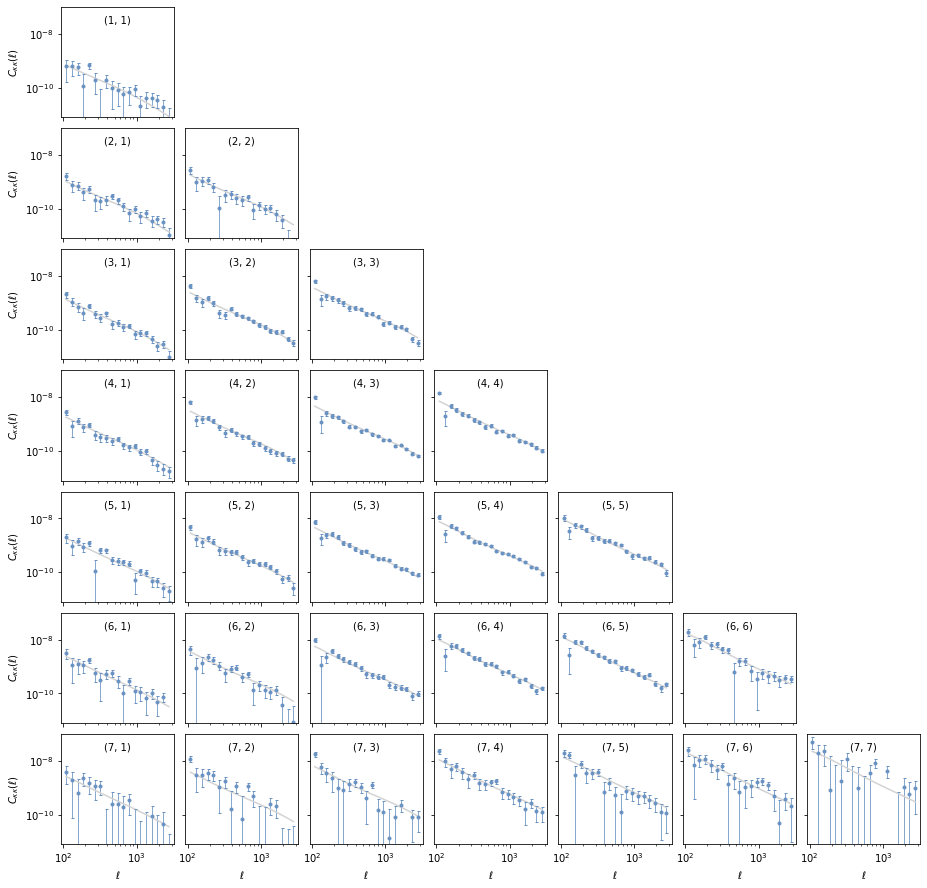

In [12]:
fig = plot_twopoint(d, theory=t, theory_cov = t_cov, datatype=EE, ratios = False, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_shear', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)
plt.savefig(dir + 'plots/' + 'cl_shear.pdf', bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shearDensity_cl_e


<Figure size 432x288 with 0 Axes>

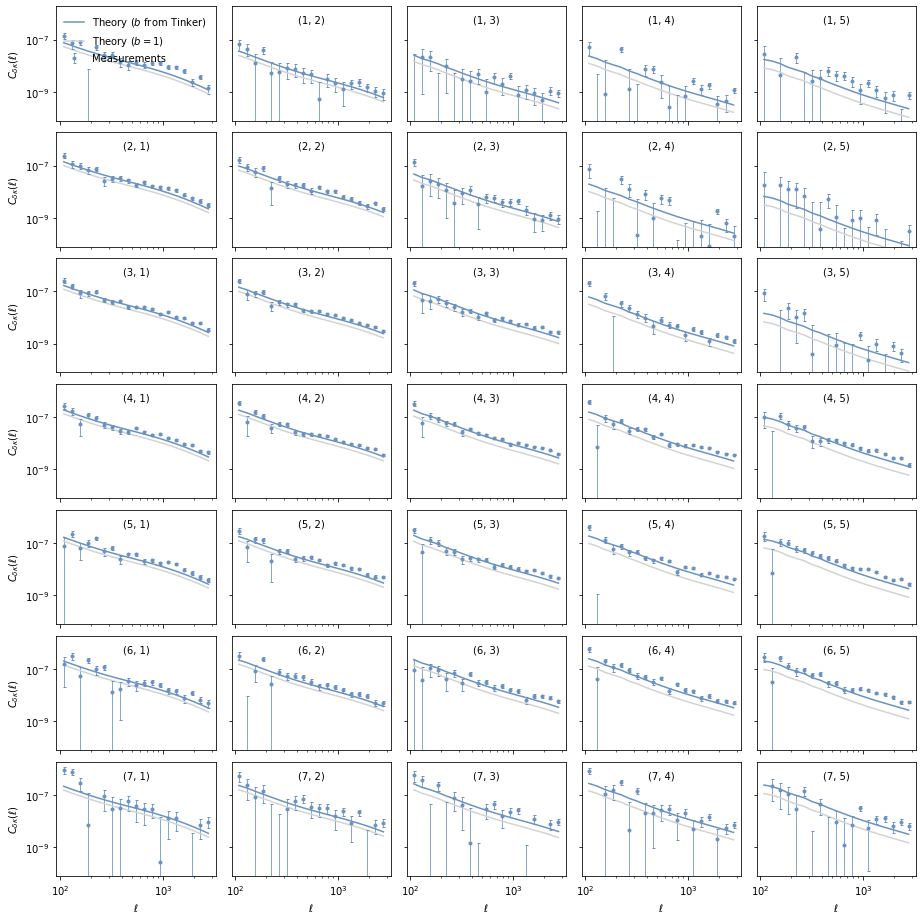

In [13]:
fig = plot_twopoint(d, theory=t, theory_cov = t_cov, datatype=ED, ratios = False, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_galaxyshear', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)
plt.savefig(dir + 'plots/' + 'cl_galaxyshear.pdf', bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_density_cl


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/sacc/sacc.py:370: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


<Figure size 432x288 with 0 Axes>

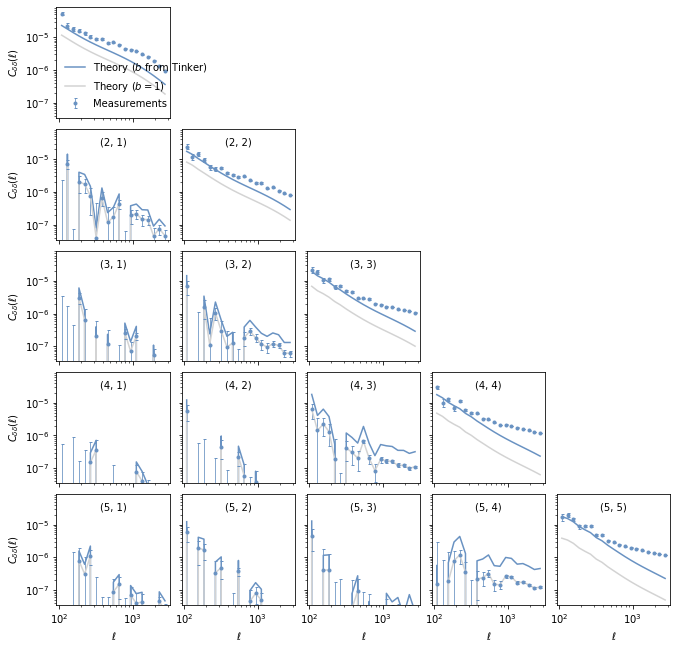

In [14]:
fig = plot_twopoint(d, theory=t, theory_cov = t_cov, datatype=DD, ratios = False, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_galaxy', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)
plt.savefig(dir + 'plots/' + 'cl_galaxy.pdf', bbox_inches = 'tight',  pad_inches = 0.1)

In [20]:
lens_density = np.array([0.018115458448473835, 0.0348763018449613, 0.05980260363102459, 0.0890867121108154, 0.1072563048039318])
def arcmin2_to_rad2(density):
    return density*60**2*41253/(4*np.pi)
lens_density_rad = arcmin2_to_rad2(lens_density)
print (1/lens_density_rad)
cl_noise_direct = 1/lens_density_rad

[4.67092073e-06 2.42617095e-06 1.41491951e-06 9.49814719e-07
 7.88912788e-07]


In [21]:
print(3600*180/np.pi*180/np.pi)
print(60**2*41253/(4*np.pi))

11818102.860042278
11818113.961265925


In [22]:
cl_noise_maps

array([6.68303721e-06, 3.84260238e-06, 5.56506195e-06, 5.21779948e-06,
       4.72824479e-06, 3.88779185e-06, 4.69881871e-06, 5.11370779e-06,
       4.91977748e-06, 4.92077812e-06, 4.56745945e-06, 4.65713359e-06,
       4.73694541e-06, 4.68820176e-06, 4.57782289e-06, 4.48991756e-06,
       4.63163837e-06, 4.64076930e-06, 4.84456018e-06])

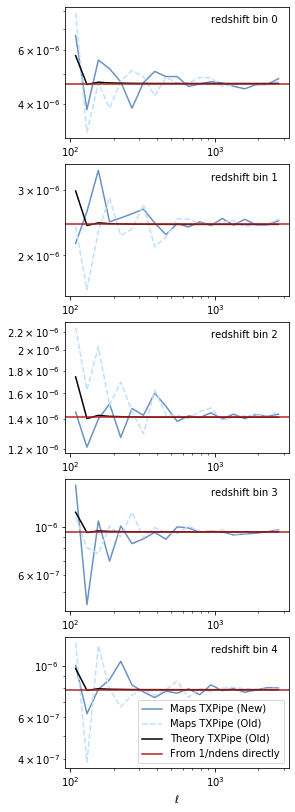

In [24]:

# plotting the noise here
fig, ax = plt.subplots(5,1, figsize = (4,14))
dir_compare = '../data_vectors/cosmodc2/december14_2021/7sbins/'
for i in range(5):
    cl_noise_maps = np.load(dir + 'cl_noise/cl_noise_maps_%d%d.npy'%(i, i))
    cl_noise_maps_old = np.load(dir_compare + 'cl_noise/cl_noise_maps_%d%d.npy'%(i, i))
    cl_noise_analytic = np.load(dir_compare + 'cl_noise/cl_noise_analytic_%d%d.npy'%(i, i))
    ax[i].plot(ell,cl_noise_maps, ls = '-', label = 'Maps TXPipe (New)', color = c[1])
    ax[i].plot(ell,cl_noise_maps_old, ls = '--', label = 'Maps TXPipe (Old)', color = c[2])
    ax[i].plot(ell,cl_noise_analytic,  ls = '-', label = 'Theory TXPipe (Old)', color = 'k')
    #ax[i].plot(np.arange(3*2048),cl_noise_analytic,  ls = '-', label = 'Theory TXPipe', color = 'k')
    ax[i].axhline(y=cl_noise_direct[i], color = 'firebrick' , label = 'From 1/ndens directly')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    #ax[i].set_ylim(ymin=10**(-10))
    ax[i].text(0.8, 0.9, 'redshift bin %d'%i, horizontalalignment='center',
                                  verticalalignment='center', transform=ax[i].transAxes)
ax[i].legend()
ax[i].set_xlabel('$\ell$')
plt.savefig(dir +'cl_noise_clustering.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)


In [12]:
def plot_errorbars(s, theory=None, theory_cov = None, datatype=None, ratios = False, plot_namaster=True):
      
    for dt in s.get_data_types():
        
        if dt == XIP or dt == XIM:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == GAMMA:
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == W:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
            print(dt)
            plt.clf()
            if dt == GAMMA:
                fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 3.2*nbins2), sharey=True, sharex=True)
            else:
                fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 2.2*nbins2), sharey=True, sharex=True)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)

            
            if plot_namaster:
                if dt == XIP:
                    err_na = np.loadtxt(dir + 'covariance_namaster/cov_xip.txt')
                if dt == XIM:
                    err_na = np.loadtxt(dir + 'covariance_namaster/cov_xim.txt')
            count =-1
            for i in range(nbins1):
                for j in range(nbins2):
                    
                    

                    theta, xi, cov = s.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)

                    #print('i, j, xi:', i, j, xi)
                    mask_ls = theta<100
                    theta = theta[mask_ls]
                    xi = xi[mask_ls]
                    cov = (cov[mask_ls]).T[mask_ls]
                    err = np.sqrt(np.diag(cov))
                    
                    if theory is not None:
                        theta_th,  xi_th = theory.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j))
                        if theory_cov is not None:
                            _, _, cov_th = theory_cov.get_theta_xi(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                        theta_th = theta_th[mask_ls]
                        xi_th = xi_th[mask_ls]
                        cov_th = (cov_th[mask_ls]).T[mask_ls]
                        err_th = np.sqrt(np.diag(cov_th))
                        
                    if plot_namaster:
                        if len(theta)>0:
                            count += 1
                            err_na_block = err_na[count*15:(count+1)*15]

                    if ratios:
                        ax[i][j].plot(theta, err/err_th, lw = 2, color = c[0], label = 'Jackknife/Theory std')
                        if plot_namaster:
                            if len(theta)>0:
                                ax[i][j].plot(theta, err_na_block/err_th, lw = 2, color = 'powderblue', label = 'Namaster/Theory std')
                                ax[i][j].plot(theta, err/err_na_block, lw = 2, color = c[2], label = 'JK/Namaster')
                    else:
                        ax[i][j].plot(theta, err, lw = 2, color = c[0], label = 'Jackknife')
                        ax[i][j].plot(theta, err_th, lw = 2,color = c[2],  label = 'Theory')
                        if plot_namaster:
                            if len(theta)>0:
                                ax[i][j].plot(theta, err_na_block, lw = 2, color = 'powderblue',  label = 'Namaster Jackie')

                    ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                                  verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
                    ax[i][j].set_xscale('log')
                    ax[i][j].set_xlim(2, 110)
                    
                    if ratios:
                        ax[i][j].set_ylim(0.6, 1.4)
                        ax[i][j].axhline(y =1, ls = ':', color = 'k')
                    else:
                        ax[i][j].set_yscale('log')
                        if datatype==XIP:
                            ax[i][j].set_ylim(10**(-7), 5*10**(-4))
                        if datatype==XIM:
                            ax[i][j].set_ylim(10**(-7), 3.5*10**(-4))  
                        if datatype==GAMMA:
                            ax[i][j].set_ylim(7*10**(-6), 4.*10**(-3))  
                        if datatype==W:
                            ax[i][j].set_ylim(10**(-3), 1.2)  


                    if i==nsbins-1: 
                        ax[i][j].set_xlabel(r'$\theta$ [arcmin]')
                    if j==0:
                        if datatype==XIP:
                            ax[i][j].set_ylabel(r'$\xi_+$')
                        if datatype==XIM:
                            ax[i][j].set_ylabel(r'$\xi_-$')
                        if datatype==GAMMA:
                            ax[i][j].set_ylabel(r'$\gamma_t$')
                        if datatype==W:
                            ax[i][j].set_ylabel(r'$w(\theta)$')
                            
                    if datatype!=GAMMA:
                        if i<j:
                            fig.delaxes(ax[i, j])

    ax[0][0].legend(frameon = False, loc = 'lower left')

    return fig


In [34]:
def corrmatrix(cov):
    cov = np.mat(cov)
    D = np.diag(np.sqrt(np.diag(cov)))
    d = np.linalg.inv(D)
    corr = d*cov*d
    return corr

def plot_cov(cov, size):
    
    ncov1 = len(cov)
    ncov2 = len(cov[0])
    
    corr = corrmatrix(cov)
    cov_vmin = np.min(corr)
    
    figsize1 = 1.22222222227*ncov1/size
    figsize2 = ncov2/size
    fig, ax = plt.subplots(1, 1, figsize=(figsize1, figsize2))
    im = ax.imshow(corr, interpolation='nearest',
                           aspect='auto', origin='lower', vmin=-0.5, vmax=1.)
    cbar = fig.colorbar(im)
    return fig

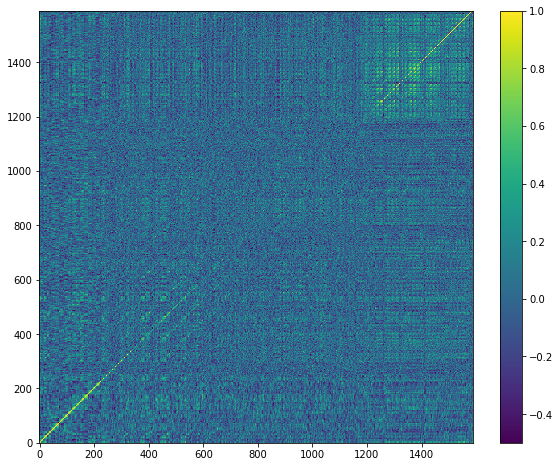

In [52]:
cov = plot_cov(d.covariance.covmat, 200)
plt.savefig(dir + 'plots/cov_3x2pt_JK.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

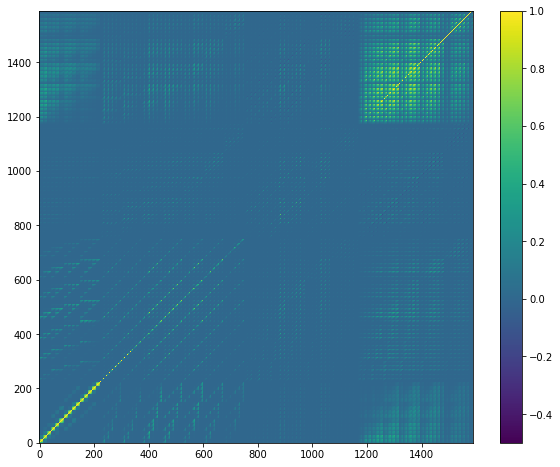

In [82]:
cov = plot_cov(t_cov.covariance.covmat, 200)
plt.savefig(dir + 'plots/cov_3x2pt_theory.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

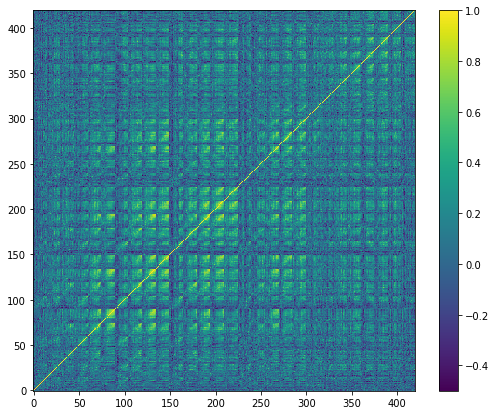

In [54]:
indices_p = d.indices('galaxy_shear_xi_plus')
cov = plot_cov(d.covariance.get_block(indices_p), 60)
plt.savefig(dir + 'plots/cov_xip_JK.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

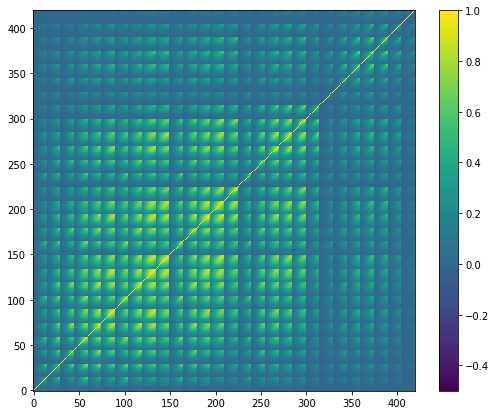

In [81]:
indices_p = t_cov.indices('galaxy_shear_xi_plus')
cov = plot_cov(t_cov.covariance.get_block(indices_p), 60)
plt.savefig(dir + 'plots/cov_xip_theory.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

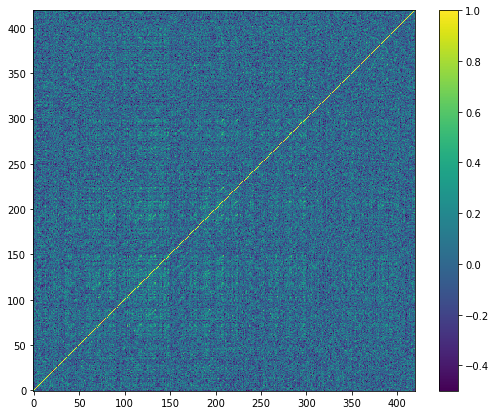

In [56]:
indices_p = d.indices('galaxy_shear_xi_minus')
cov = plot_cov(d.covariance.get_block(indices_p), 60)
plt.savefig(dir + 'plots/cov_xim_JK.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

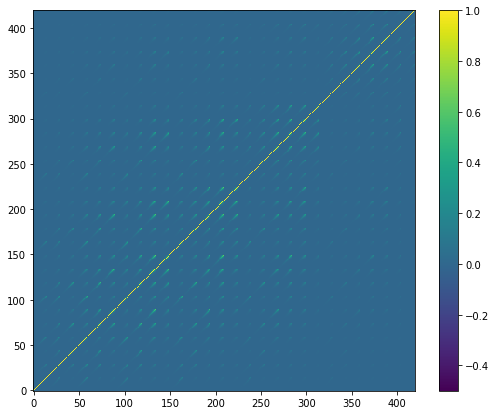

In [57]:
indices_p = t_cov.indices('galaxy_shear_xi_minus')
cov = plot_cov(t_cov.covariance.get_block(indices_p), 60)
plt.savefig(dir + 'plots/cov_xim_theory.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

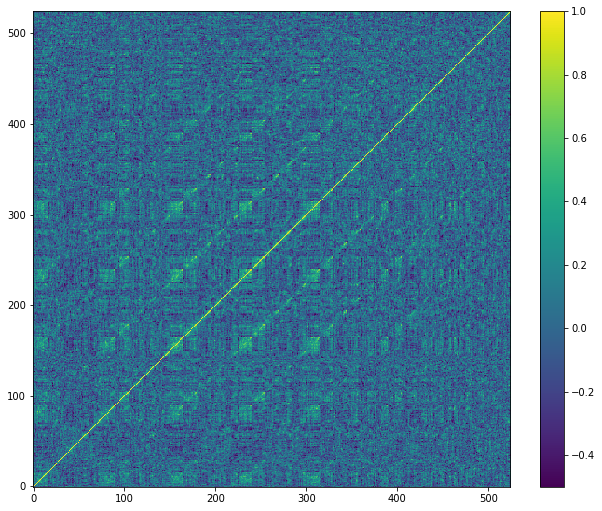

In [58]:
indices = d.indices(GAMMA)
cov = plot_cov(d.covariance.get_block(indices), 60)
plt.savefig(dir + 'plots/cov_gt_JK.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

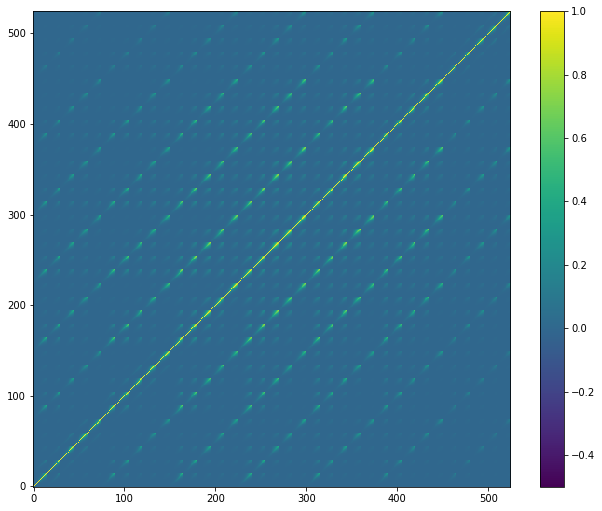

In [78]:
indices = t_cov.indices(GAMMA)
cov = plot_cov(t_cov.covariance.get_block(indices), 60)
plt.savefig(dir + 'plots/cov_gt_theory.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

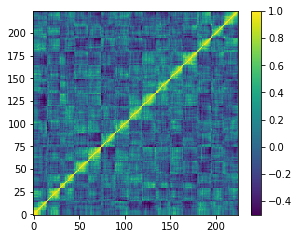

In [80]:
indices = d.indices(W)
cov = plot_cov(d.covariance.get_block(indices), 60)
plt.savefig(dir + 'plots/cov_w_JK.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)

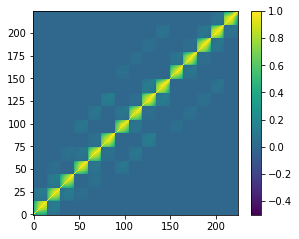

In [79]:
indices = t_cov.indices(W)
cov = plot_cov(t_cov.covariance.get_block(indices), 60)
plt.savefig(dir + 'plots/cov_w_theory.png', dpi = 300, bbox_inches = 'tight',  pad_inches = 0.1)